# Классификация изображений цифр банковской карты

_Импорт библиотек_

In [2]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

import os
import cv2 as cv
import random

from PIL import Image

from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping

from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense

Using TensorFlow backend.


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

_Загрузка данных:_

In [4]:
folder_path = os.path.dirname('~/Классификация изображений цифр банковской карты/Bank Card Number Dataset/')

original_data_path = os.path.join(folder_path, 'original/')

In [5]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [6]:
imgs = []

for i in range(10):
    digit = load_images_from_folder(original_data_path + str(i))
    imgs.append(digit)

_Изменяем размеры изображений > 58 х 85:_

In [7]:
imgs_resized = []

for number in imgs:
    digit_resized = []
    for img in number:
        resized = cv.resize(img, dsize=(58, 85), interpolation=cv.INTER_CUBIC) #average image dimensions = 85.14011299435029 (height) x 58.110734463276835 (width)
        digit_resized.append(resized)
    imgs_resized.append(digit_resized)

_Расширяем набор данных и для каждого класса будет одинаковое количество данных:_

In [8]:
imgs_equal = []
max_img_count = 500

for number in imgs_resized:
    count=0
    while(count != max_img_count):
        rand_img = random.sample(number, 1)[0]
        rows, cols, _ = rand_img.shape
        matrix = cv.getRotationMatrix2D((cols,rows),random.randint(-10,10),1)
        rotated = cv.warpAffine(rand_img,matrix,(cols,rows), flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REPLICATE)

        imgs_equal.append(rotated)
        
        count+=1

In [9]:
def onehotencode(index, n):
    return [1.0 if i == index else 0.0 for i in range(n)]

In [10]:
labels = []
for i in range(10):
    for j in range(max_img_count):
        labels.append(onehotencode(i, 10))

_Нормализуем изображения, значения пикселей теперь будут в диапазоне от 0 до 1:_

In [11]:
data = np.asarray(imgs_equal) / 255.0
labels = np.asarray(labels)

_Делим массив данных на тестовые и тренировочные данные:_

In [12]:
from sklearn.model_selection import train_test_split

SEED = 1234
np.random.seed = SEED

X_train, X_test, Y_train, Y_test = train_test_split(data, labels, train_size=0.7)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [13]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((3500, 85, 58, 3), (1500, 85, 58, 3), (3500, 10), (1500, 10))

_Создание модели:_

In [19]:
# Входной слой (передаем также размер изображений)
input_layer = tf.keras.layers.Input((85, 58, 3))

# Скрытые слои
hidden_layer_1 = tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3),  activation=tf.keras.activations.relu)(input_layer)
hidden_layer_2 = tf.keras.layers.Conv2D(filters=10, kernel_size=(5,5),  activation=tf.keras.activations.relu)(hidden_layer_1)
hidden_layer_3 = tf.keras.layers.Conv2D(filters=10, kernel_size=(7,7),  activation=tf.keras.activations.relu)(hidden_layer_2)
hidden_layer_4 = tf.keras.layers.Flatten()(hidden_layer_3)

# Выходной слой
output_layer = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)(hidden_layer_4)

# Собираем модель
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

#
model.compile(tf.keras.optimizers.SGD(0.01), tf.keras.losses.categorical_crossentropy, metrics=['mse', 'accuracy'])

_Выводим информацию по модели:_

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 85, 58, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 83, 56, 10)        280       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 79, 52, 10)        2510      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 73, 46, 10)        4910      
_________________________________________________________________
flatten_3 (Flatten)          (None, 33580)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                335810    
Total params: 343,510
Trainable params: 343,510
Non-trainable params: 0
_________________________________________________________________


_Запуск модели:_

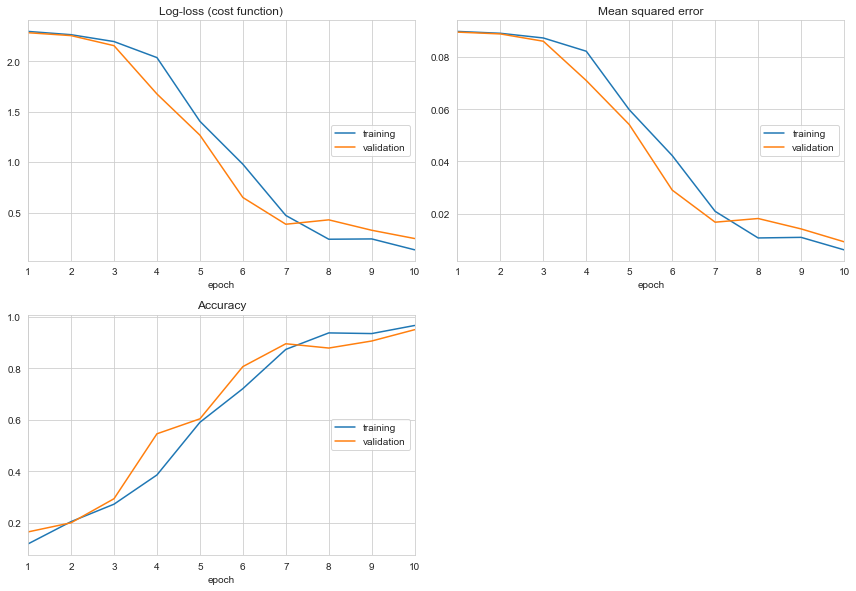

In [21]:
EPOCHS = 10
BATCH_SIZE = 80

history = model.fit(X_train, Y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(X_test, Y_test),
              verbose=0,
              callbacks=[PlotLossesKeras()],
              shuffle=True);

_Сохраняем модель:_

In [22]:
model.save('bank_card_model1.h5')

_Загружаем предыдущую: (если требуется)_

In [ ]:
loaded_model = tf.keras.models.load_model('bank_card_model.h5')

_Проверка на рандомных значениях из набора данных:_

In [23]:
print("a g") # a – actual images, g – guessing result

for x in range(30):
    random_index = random.randint(0, 5000)
    img = data[random_index]
    img = np.expand_dims(img, axis=0)

    guess = np.argmax(model.predict(img))
    actual = np.argmax(labels[random_index])
    print(actual, guess)

a g
3 3
9 9
9 9
1 1
2 2
4 4
6 6
2 2
8 8
3 3
1 1
0 0
9 9
6 6
3 3
1 1
5 5
0 0
8 8
3 3
7 7
7 7
9 9
4 4
7 7
6 6
7 7
7 7
4 4
8 8


_Проверка на рандомных значениях из оригинальных данных:_

In [24]:
def load_image_from_folder(folder):
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder, filename))
        resized = cv.resize(img, dsize=(58, 85), interpolation=cv.INTER_CUBIC) #average image dimensions = 85.14011299435029 (height) x 58.110734463276835 (width)

        return np.asarray(resized)/255.0

In [25]:
print("a g")

for i in range(10):
    digit = load_image_from_folder(original_data_path + str(i))
    
    random_index = random.randint(0, 5000)
    img_for_test = np.expand_dims(digit, axis=0)

    guess = np.argmax(model.predict(img_for_test))
    actual = i
    print(actual, guess)

a g
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
